In [1]:
from networks.UNets3D import UNet3D
import matplotlib.pyplot as plt
import torch
import nibabel as nib
import numpy as np
from celluloid import Camera
from IPython.display import HTML

In [2]:
model = UNet3D(in_channels=1, out_channels=3, final_sigmoid=False)
model.load_state_dict(torch.load(r"D:\Udacity\Quantifying Hippocampus Volume for Alzheimer's Progression\ML pipeline\out\best solution\model.pth"))

<All keys matched successfully>

In [3]:
def med_reshape(image, new_shape):
    reshaped_image = np.zeros(new_shape)

    size = image.shape
    reshaped_image[:size[0], :size[1], :size[2]] = image

    return reshaped_image

In [4]:
def segment_hippocampus(model, volume_path):
    volume = nib.load(volume_path).get_fdata()
    reshaped_volume = med_reshape(volume, (48, 64, 64))
    volume_tensor = torch.from_numpy(reshaped_volume.astype(np.single)/np.max(reshaped_volume)).unsqueeze(0).unsqueeze(0)
    pred = model(volume_tensor)
    pred = torch.squeeze(pred.detach())
    pred = torch.argmax(pred, dim=0)
    pred = pred.numpy()
    pred = pred[: volume.shape[0], : volume.shape[1], : volume.shape[2]]
    pred[pred > 0] = 1
    volume_in_mm3 = np.sum(pred > 0)

    fig = plt.figure()
    camera = Camera(fig)
    for i in range (volume.shape[0]):
        plt.imshow(volume[i, :, :], cmap='bone')
        mask = np.ma.masked_where (pred[i]==0, pred[i])
        plt.imshow(mask, alpha=0.8, cmap='Wistia')
        camera.snap()
    
    animation = camera.animate()
    video = HTML(animation.save("hippocampus_segmentation.mp4", writer="ffmpeg", fps=10))

    return video, volume_in_mm3

c:\Users\user\anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\Users\user\anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
c:\Users\user\anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
c:\Users\user\anaconda3\lib\site-packages\matplotlib\image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


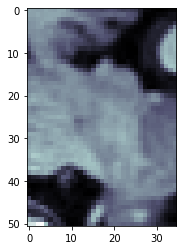

In [5]:
video, volume_in_mm3 = segment_hippocampus(model, r"D:\Udacity\Quantifying Hippocampus Volume for Alzheimer's Progression\data\TrainingSet\images\hippocampus_001.nii.gz")

In [6]:
volume_in_mm3

3147